# Perception on Public Security in the United States of Mexico

## Introduction

After a recent trip to Mexico, I decided to explore the website of the National Institute of Statistics and Geography of Mexico ([INEGI](https://en.www.inegi.org.mx/default.html)) and use this project as an opportunity to learn more about the country. 

After exploring the data available on the website, I decided to investigate the issue of perceived insecurity within the country. I chose this topic for 2 main reasons: 

1) The data available on the INEGI website looks complex and interesting enough to investigate: the survey has been iterated for a number of years (quarterly, from 2010 to 2025), and it's divided by state, which allows both a temporal and a geographic analysis. 

2) The dataset contains many different indicators, so it can be manipulated to extract different datasets. 

2) While planning my trip, I was surprised for the concern expressed by my Mexican friends (both male and female). Also, during my trip, I noticed that my own perception of security (or lack thereof) was different, based on the state and town I was visiting. That makes the data interesting at a personal level. 

### Project scope

The goal of this project is to investigate the following points: 

- How has the perception of public insecurity in Mexico changed over the past 15 years, by sex and by state?  
- How does it look like, now?
- How does it relate with the crime rate? 

For more details on the structure of the project, refer to the [README](project/README.md). 

## 1. Data import

All the packages required for the project are imported.

In [33]:
# data import
import requests 
import openpyxl

# data analysis
import pandas as pd
import numpy as np
from numpy.polynomial import polynomial as npp

# plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

### 1.1 API requests and download

After exploring the webiste of INEGI, I found 2 ways of sourcing the data: 

- using the API 
- dowloading the data in .xlsx format. 

I explored both ways. 

#### API requests

The API requires a token (or key), which can be requested for free by registering with an email address. The API requests can be created using a [Query Builder](https://en.www.inegi.org.mx/servicios/api_indicadores.html) that inputs parameters such as: 

- indicator,
- geographic area,
- language (Spanish or English).

The [documentation](https://en.www.inegi.org.mx/servicios/api_indicadores.html) is quite clear and accessible, and available in Spanish and English.

However, the API has some limitations:

1. it returns responses in .json, .jsonp, or .xml, which make it hard to read and manipulate the data with Pandas (see below);
2. it only allows to request data about one area at the time, which does not allow to compare data points across regions;
3. it allows to input max 10 indicators per request, which returns a partial dataset and limits analysis.

In [34]:
# code provided by chatGPT: https://chatgpt.com/share/6950450b-d294-800f-8cb4-c585e1a7fe7f

# 1. Fetch the JSON from the API
url = "https://en.www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6200028417,6200028418,6200028419,6200028420,6200028431,6200028430,6200028427,6200028425,6200028423,6200028433/en/00,01/true/BISE/2.0/0f18317c-23e8-90bd-c373-f2e07a38e907?type=json"
response = requests.get(url)
data = response.json()  # Convert response to Python dict

# 2. Create a DataFrame from the "Series" list
series_df = pd.json_normalize(data["Series"])

# 3. Also flatten the "OBSERVATIONS" nested list
obs_df = pd.json_normalize(
    data["Series"],
    record_path=["OBSERVATIONS"],
    meta=["INDICADOR"],
    errors="ignore"
)

# 4. Merge Series-level with Observations
df = series_df.drop(columns=["OBSERVATIONS"]).merge(
    obs_df,
    on="INDICADOR",
    how="inner"
)

# preview data 
df.head(5)

,INDICADOR,FREQ,TOPIC,UNIT,UNIT_MULT,NOTE,SOURCE,LASTUPDATE,STATUS,TIME_PERIOD,OBS_VALUE,OBS_EXCEPTION,OBS_STATUS,OBS_SOURCE,OBS_NOTE,COBER_GEO
0,6200028417,3,163,3,,,"1024,1027,1054,1171,1795,2196,2782,2822,2928,2...",18/09/2025 12:00:00 a. m.,None,2025,34.35740488780000000000,None,3,,,0
1,6200028418,3,163,3,,5255,"1024,1027,1054,1171,1795,2196,2782,2822,2928,2...",18/09/2025 12:00:00 a. m.,None,2025,18.44711426750000000000,None,3,,,0
2,6200028419,3,163,3,,5256,"1024,1027,1054,1171,1795,2196,2782,2822,2928,2...",18/09/2025 12:00:00 a. m.,None,2025,63.80192530400000000000,None,3,,,0
3,6200028420,3,163,3,,5257,"1024,1027,1054,1171,1795,2196,2782,2822,2928,2...",18/09/2025 12:00:00 a. m.,None,2025,23.72884692830000000000,None,3,,,0
4,6200028431,3,163,3,,5267,"1024,1054,1171,1795,2196,2782,2822,2928,2974,2...",18/09/2025 12:00:00 a. m.,None,2025,16.67994456540000000000,None,3,,,0


Reading the API response with Pandas is not particularly easy, nor straightforward (it's not enough to use [pandas.read_json()](https://pandas.pydata.org/docs/reference/api/pandas.read_json.html)). 

Morever, once the data is imported to a dataframe, it is still quite hard to read, because indicators and geographic areas are identified with IDs instead of full names, so they should be remapped.

It would be possible to make the data complete, creating multiple requests (iterating through areas and indicators) and remapping names. However, this would add complexity to the task. For this reason, I decided the most effective way of sourcing the data was downloading the full dataset in .xlsx format. 

<div class="alert alert-block alert-info">
<b>API KEYS:</b> If I had decided to use the API to get the data for my analysis, I would have stored my API key in an .env file, which would have been ignored by git and not published to my repository. In this way, another user executing the code would need their own key, and my sensitive data would be protected. Since in this particular case the key is not used in the code but just as example, I decided an exeception could be made. Source: https://medium.com/@oadaramola/a-pitfall-i-almost-fell-into-d1d3461b2fb8. 
</div>

#### Data download

The datasets available on the website of INEGI in .xlsx format include multiple tabs: one for the data, and one or more for metadata. See: https://en.www.inegi.org.mx/app/descarga/?t=163. 

The dataset on *Perception of Public Security* was downloaded and added to the repository in the folder *data*: [Perception dataset](project/data/percepcion_english_00.xlsx). It includes 3 tabs: 

- the dataset,
- metadata for each indicator and for each year,
- metadata on each indicator. 

Pandas.read_excel is used to read the full dataset (1st tab of the file). 

The dataset includes all the indicators and geographic areas, including IDs and full names. 

In [35]:
# set file path 
filepath = "./data/public_security.xlsx"

# read data. See: # see: https://pandas.pydata.org/docs/reference/api/pandas.read_json.html
df = pd.read_excel(filepath, sheet_name='valor', skiprows=4)

# preview the data
df.head()

,cve_entidad,desc_entidad,cve_municipio,desc_municipio,id_indicador,indicador,2010,2011,2012,2013,...,2023/t4,2024,2024/t1,2024/t2,2024/t3,2024/t4,2025,2025/t1,2025/t2,unidad_medida
0,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002198,Rate of people aged 18 and older who considere...,NaN,69536.343084,66622.674217,72322.456768,...,NaN,73621.540745,NaN,NaN,NaN,NaN,75556.050590,NaN,NaN,"Cases per 100,000 inhabitants"
1,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002235,Rate of economic units that consider their nei...,NaN,NaN,5460.456292,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cases per 10,000 economic units"
2,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002237,Rate of economic units that consider their sta...,NaN,NaN,7602.826537,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cases per 10,000 economic units"
3,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002238,Rate of economic units that consider their mun...,NaN,NaN,7052.320400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cases per 10,000 economic units"
4,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200005815,Rate of people aged 18 years and over that con...,NaN,39481.723643,38674.118886,44011.361167,...,NaN,40210.785898,NaN,NaN,NaN,NaN,40462.996387,NaN,NaN,"Cases per 100,000 inhabitants"


The dataset is saved to .csv format in the folder "data", so the file can be opened from the repository (which is not possible for .xlsx). 

In [36]:
# save dataframe to csv. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
df.to_csv('./data/public_security.csv', index=False)

### 1.2 Data exploration

The dataset is explored to know more about its size and data points.  

#### Series

Series (or columns) are explored. The dataset includes 69 columns: 

- the first columns (0-5) provide information on the geographic area and indicators and values: IDs could be removed to make the dataset easier to handle. 
- the rest of the columns provodide quarterly data (ES: *trimester*, or *t*), recorded from 2010 through 2025. Many of these columns are near empty, so they should be removed to keep only yearly data. 
- the last column provides information on the value types (absolute numbers, percentages, units per 100,000 inhabitants), which is useful to understand values. 

Data types are a mix of strings (objects) and integers (IDs) and floats (values). 

In [37]:
# show series and data types. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 70 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cve_entidad     1485 non-null   int64  
 1   desc_entidad    1485 non-null   object 
 2   cve_municipio   1485 non-null   int64  
 3   desc_municipio  1485 non-null   object 
 4   id_indicador    1485 non-null   int64  
 5   indicador       1485 non-null   object 
 6   2010            14 non-null     float64
 7   2011            1351 non-null   float64
 8   2012            1451 non-null   float64
 9   2013            1352 non-null   float64
 10  2013/t3         1 non-null      float64
 11  2013/t4         1 non-null      float64
 12  2014            1451 non-null   float64
 13  2014/t1         1 non-null      float64
 14  2014/t2         1 non-null      float64
 15  2014/t3         1 non-null      float64
 16  2014/t4         1 non-null      float64
 17  2015            1352 non-null   f

#### Geographic areas

Two data points refer to geographic areas: desc_entidad (EN: *entity*) and desc_municipio (*municipality*). Both are listed to understand their meaning. 

In [38]:
# show unique values of 'desc_entidad'. see: https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html
df['desc_entidad'].unique()

array(['Estados Unidos Mexicanos', 'Aguascalientes', 'Baja California',
       'Baja California Sur', 'Campeche', 'Coahuila de Zaragoza',
       'Colima', 'Chiapas', 'Chihuahua', 'Ciudad de México', 'Durango',
       'Guanajuato', 'Guerrero', 'Hidalgo', 'Jalisco', 'México',
       'Michoacán de Ocampo', 'Morelos', 'Nayarit', 'Nuevo León',
       'Oaxaca', 'Puebla', 'Querétaro', 'Quintana Roo', 'San Luis Potosí',
       'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas', 'Tlaxcala',
       'Veracruz de Ignacio de la Llave', 'Yucatán', 'Zacatecas'],
      dtype=object)

In [39]:
# show unique values of 'desc_municipio'
df['desc_municipio'].unique()

array(['Estados Unidos Mexicanos', 'Estatal'], dtype=object)

Desc_municipio refers to the country, while desc_entitad to the State, which is the relevant information. 

#### Indicators

The Excel tab with metadata on indicators is imported to know more about the number and type of indicators. 

In [40]:
# show indicators 
indicators = pd.read_excel(filepath, sheet_name='notas', skiprows = 4)

# show
indicators.head()

,id,indicador,descripcion
0,6200002198,Rate of people aged 18 and older who considere...,The rate of people who feel their state is ins...
1,6200002198,Rate of people aged 18 and older who considere...,Due to the health emergency generated by the S...
2,6200002198,Rate of people aged 18 and older who considere...,Due to the health emergency generated by the S...
3,6200002235,Rate of economic units that consider their nei...,The rate of economic units that considered uns...
4,6200002237,Rate of economic units that consider their sta...,The rate of economic units that considered uns...


Some indicators seem to be duplicates, which creates some noise. 

In [41]:
# show count of indicators (by id)
print(f'Number of indicators (ID): {len(indicators['id'])}')

# show count of unique indicators (by id)
print(f'Unique indicators (ID): {len(indicators['id'].unique())}')

Number of indicators (ID): 86
Unique indicators (ID): 59


In [42]:
# show unique indicators 
list(indicators['indicador'].unique())

['Rate of people aged 18 and older who considered unsafe their state, for every hundred thousand inhabitants of 18 years and over',
 'Rate of economic units that consider their neighborhood or locality as unsafe, per ten thousand economic units',
 'Rate of economic units that consider their state as unsafe, per ten thousand economic units',
 'Rate of economic units that consider their municipality or delegation as unsafe, per ten thousand economic units',
 'Rate of people aged 18 years and over that consider their neighborhood or locality as unsafe, per hundred thousand population aged 18 years and over',
 'Rate of people aged 18 years and over that consider their municipality or delegation as unsafe, per hundred thousand population aged 18 years and over',
 'Percentage of population aged 18 years and over who consider unsafe their city',
 'Percentage of depositions of venues invasion',
 'Percentage of depositions of alcohol consumption in the street',
 'Percentage of depositions of ho

Indicators provide information on: 

- people's perception on public safety within their area (from neighborhood to state). Values expressed either as rates, rate per 100,000 inhabitants, or absolute numbers, by sex and in total. 

- pecentage of depositions for several crime types.

- perception of corruption / insecurity by the population. 

Duplicate rows are removed, and the indicators are saved to a .csv file in the folder [Data](./data). 

In [43]:
# remove duplicate rows by id. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
indicators.drop_duplicates(subset=['id'], inplace=True)

# save to csv 
indicators.to_csv('./data/indicators.csv', index=False)

## 2. Data clean-up

### 2.1 Remove columns

Irrelevant columns are removed from the dataframe

- cve_minicipio and disc_municipio (which have the same values throughout the whole dataset),
- columns about quarterly data (which are mostly empty).

In [44]:
# remove entidad. See: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
data = df.drop(columns=['cve_municipio', 'desc_municipio'])

# remove quarterly data. See: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.filter.html
data = data.filter(regex = "^[a-z0-9_]+(?!\t)$", axis = 1)

### 2.2 Label Translation

Untranslated labels are replaced with labels in English to enhance clarity.

In [45]:
# translate column labels
new_columns = {
    'cve_entidad': 'state ID',
    'desc_entidad': 'state',
    'indicador': 'indicator',
    'id_indicador': 'indicator ID',
    'unidad_medida': 'unit of measure'}

# rename columns. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
data.rename(columns=new_columns, inplace=True)

### 2.3 Missing values

Columns are explored to identify and remove missing values. From the first exploration of the data (see cell 5), it is known that the total number of rows in the dataset is 1485. 

In [46]:
# count missing values
data.isnull().sum()

state ID              0
state                 0
indicator ID          0
indicator             0
2010               1471
2011                134
2012                 34
2013                133
2014                 34
2015                133
2016                  1
2017                100
2018                  1
2019                166
2020                 67
2021                199
2022                 34
2023                133
2024                133
2025                148
unit of measure       0
dtype: int64

#### Dealing with missing values 

A number of strategies were considered to deal with missing values: 

- removing columns and/or rows, which means that some data points are lost entirely. 
- imputation: adding to the cell the median/mean value of the series, optionally based on the values in another series. This is useful if few instances is missing; if a large amount of data points are missing, it can result in a loss of variation in the dataset. 
- forward fill and backward fill: carrying forward the last observed value, or carrying backward the next value (useful for time series). 

Source: https://medium.com/@pingsubhak/handling-missing-values-in-dataset-7-methods-that-you-need-to-know-5067d4e32b62. 

For this dataset, the strategy is: 

- removing the column 2010 entirely, since most values are missing. 
- removing rows with empty values [not the best approach, because it means that data on some States is lost entirely. This might be changed at a later stage]. 


In [47]:
# drop column 2010
data.drop(['2010'], axis = 1, inplace=True)

# drop rows with missing values. See:  https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
data.dropna(inplace=True)

After empty columns and rows are removed from the dataframe, the total number of rows is 1238 (247 less than the original dataframe). 

In [48]:
# show columns 
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1238 entries, 0 to 1484
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state ID         1238 non-null   int64  
 1   state            1238 non-null   object 
 2   indicator ID     1238 non-null   int64  
 3   indicator        1238 non-null   object 
 4   2011             1238 non-null   float64
 5   2012             1238 non-null   float64
 6   2013             1238 non-null   float64
 7   2014             1238 non-null   float64
 8   2015             1238 non-null   float64
 9   2016             1238 non-null   float64
 10  2017             1238 non-null   float64
 11  2018             1238 non-null   float64
 12  2019             1238 non-null   float64
 13  2020             1238 non-null   float64
 14  2021             1238 non-null   float64
 15  2022             1238 non-null   float64
 16  2023             1238 non-null   float64
 17  2024             12

## 3. Analysis: Perceived insecurity among men and women, about their State and Municipality

**About this section**

This section investigates how the perception of insecurity among men and women has evolved in the year range 2011-2025, both about their State and their Municipality. The goal is to investigate: 

- differences and/or similarities between the State and Municipality, 
- differences and/or similarities between men and women, 
- trends in perceived insecurity between 2011 and 2025.


The indicators considered are: 
1) 6204327084, Rate of people aged 18 years and over **who consider their state to be unsafe**, per every one hundred thousand inhabitants aged 18 years and over, **men**;

2) 6204327085, Rate of people aged 18 years and over **who consider their state insecure**, per every one hundred thousand inhabitants aged 18 and over, **women**;

3) 6204327086, Rate of people aged 18 years and over **who consider their municipality or delegation to be unsafe**, per every one hundred thousand inhabitants aged 18 years and over, **men**;

4) 6204327087, Rate of people aged 18 years and over **who consider their municipality or delegation to be unsafe**, per every one hundred thousand inhabitants aged 18 years and over, **women**. 

### 3.1 Data preparation

A subset with the relevant data is extracted from the dataframe, based on these criteria:

- the four indicators above 
- the state = United States of Mexico (national average). 

In [49]:
# select subset for indicators by sex 
security_data = data[(data['indicator ID']== 6204327084) | (data['indicator ID']== 6204327085) | (data['indicator ID']== 6204327086) | (data['indicator ID']== 6204327087) ]
# select subset for indicators by state (United States of Mexico))
security_data = security_data[security_data['state ID'] == 0]

# set indicators as index 
security_data = security_data.set_index('indicator ID')

# show 
security_data.head(3)

,state ID,state,indicator,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,unit of measure
indicator ID,,,,,,,,,,,,,,,,,,,
6204327084,0,Estados Unidos Mexicanos,Rate of people aged 18 years and over who cons...,66890.111026,64118.476781,69617.056542,69789.398905,69813.951453,69029.295661,71300.086465,76298.049687,75402.185998,74667.832897,72008.054681,71839.184476,70000.913221,69298.906629,70949.460191,"Cases per 100,000 inhabitants"
6204327085,0,Estados Unidos Mexicanos,Rate of people aged 18 years and over who cons...,71943.225612,68777.403637,74716.102503,76267.501601,76163.569081,75261.596065,76935.362086,82101.835803,82042.436583,81735.064641,78792.132963,79410.575547,78604.856014,77294.414283,79426.707086,"Cases per 100,000 inhabitants"
6204327086,0,Estados Unidos Mexicanos,Rate of people aged 18 years and over who cons...,56802.709413,55164.694724,60014.419763,60833.322193,60470.173236,61727.239273,62695.309034,66166.464847,66328.786362,66372.520385,61386.332953,60334.784798,58384.108149,57708.657000,59572.400731,"Cases per 100,000 inhabitants"


Metadata is removed, so that the only columns left are: 
- indicator ID 
- yearly values. 

In [50]:
# remove unnecessary columns 
col_to_remove = ['state ID', 'state','indicator','unit of measure']

security_data.drop(columns=col_to_remove, inplace=True)

# show
security_data.head(3)

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
indicator ID,,,,,,,,,,,,,,,
6204327084,66890.111026,64118.476781,69617.056542,69789.398905,69813.951453,69029.295661,71300.086465,76298.049687,75402.185998,74667.832897,72008.054681,71839.184476,70000.913221,69298.906629,70949.460191
6204327085,71943.225612,68777.403637,74716.102503,76267.501601,76163.569081,75261.596065,76935.362086,82101.835803,82042.436583,81735.064641,78792.132963,79410.575547,78604.856014,77294.414283,79426.707086
6204327086,56802.709413,55164.694724,60014.419763,60833.322193,60470.173236,61727.239273,62695.309034,66166.464847,66328.786362,66372.520385,61386.332953,60334.784798,58384.108149,57708.657000,59572.400731


The data is transposed, so that indicators become columns, and years become the index of the dataframe. 

In [51]:
# transpose data. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transpose.html
new_security_data = security_data.transpose()

# rename columns
new_security_data.columns = ['State, Men', 'State, Women','Municipality, Men', 'Municipality, Women']

# preview new data
new_security_data.head(3)

,"State, Men","State, Women","Municipality, Men","Municipality, Women"
2011,66890.111026,71943.225612,56802.709413,63393.150545
2012,64118.476781,68777.403637,55164.694724,60575.019740
2013,69617.056542,74716.102503,60014.419763,65578.422145


Values are converted to percentages: 66890.111026 --> 66.89%. Since the unit of measure is not the absolute number, but the n. of people every 100 000 inhabitants, it's not necessary to use weights. 

In [52]:
# convert values to % and round. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.round.html
for col in new_security_data: 
    new_security_data[col] = round(new_security_data[col] * 100 / 100000, 2)

# preview
new_security_data.head(3)

,"State, Men","State, Women","Municipality, Men","Municipality, Women"
2011,66.89,71.94,56.80,63.39
2012,64.12,68.78,55.16,60.58
2013,69.62,74.72,60.01,65.58


### 3.2 Plots: show the data in subplots

Two subplots are created to show: 
- rate of people aged 18 or more who perceive their State as insecure, by sex,
- rate of people aged 18 or more who perceive their Municipality as insecure, by sex. 

I chose to represent the value expressed for every 100,000 inhabitants, instead of the total number (which is also provided in the original dataset), becuase this unit of measure makes the plot easier to read and gives a better idea of proportoion (rate of insecurity/total population).

Note: Althought these plots are created with Matplotlib, I added a Seaborn theme to make them stilistically consistent with the other plots in the project. 

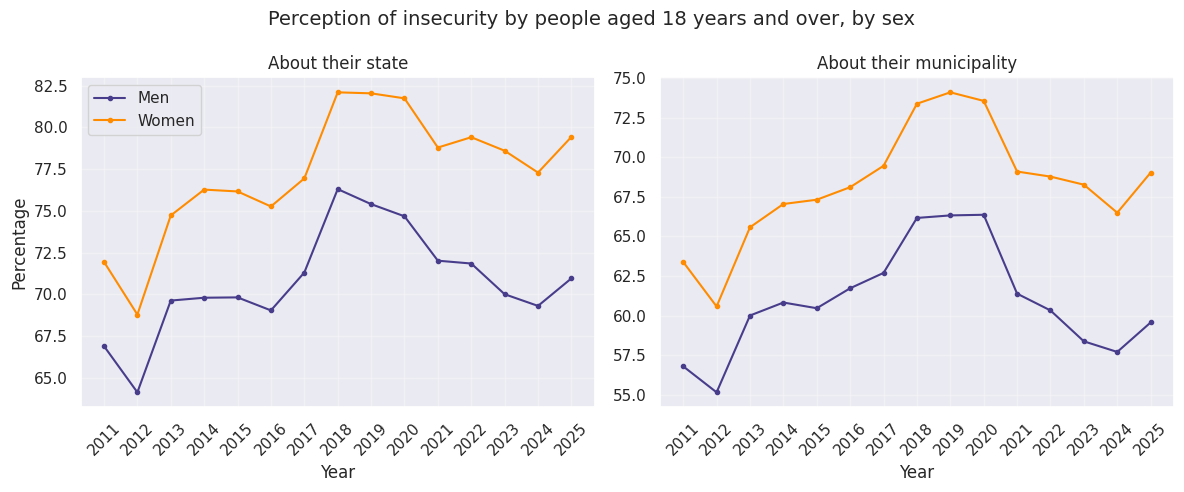

In [53]:
# set seaborne theme, to adjust the plots with the other plots in the project
# see: https://seaborn.pydata.org/generated/seaborn.set_theme.html
sns.set_theme(rc={'figure.figsize':(7,10)},color_codes=True)

# create subplots: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

axes[0].plot(new_security_data.index, new_security_data['State, Men'], color = 'darkslateblue', label = 'Men', marker = '.')
axes[0].plot(new_security_data.index, new_security_data['State, Women'], color = 'darkorange', label = 'Women', marker = '.')
axes[0].set_title('About their state', wrap = True)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Percentage')
axes[0].tick_params("x", rotation=45)
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

axes[1].plot(new_security_data.index, new_security_data['Municipality, Men'],color = 'darkslateblue', label = 'Men', marker = '.')
axes[1].plot(new_security_data.index, new_security_data['Municipality, Women'], color = 'darkorange', label = 'Women', marker = '.')
axes[1].set_title('About their municipality', wrap = True)
axes[1].set_xlabel('Year')
axes[1].tick_params("x", rotation=45)
axes[1].grid(True, alpha=0.3)

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.suptitle.html
plt.suptitle('Perception of insecurity by people aged 18 years and over, by sex', size = 14)
plt.tight_layout()

# save plot
plot_name = '3_insecurity_by_sex_and_local'
plot_dir = './data/plots/'
plt.savefig(plot_dir + plot_name + '.png')

plt.show()

### 3.3 Analysis 

The plots show very similar trends. Perceived insecurity seems to decrease between 2011 and 2012, then it increases gradually and peaks in 2018, before descreasing again. Overall, perceived insecurity for both indicators and both sexes is higher in 2025 than in 2011.

The increases in insecurity in 2012 and 2024 are interesting, because both were election years. At the same time, 2018 was also an election year and it shows a national descrease in insecurity, so the two things might be unrelated. It would be interesting to investigate correlations between these indicators and political events in the country, both at a national and regional (state) level. 

**Women vs men**

Comparing perceived insecurity by sex shows another clear trend, with women perceiving higher insecurity, both about their state and their municipality (or town). On average, women show: 
- 6.6% more insecurity than men, about their state,
- 7.3% more insecurity then men, about their municipality.

**State vs Municipality**

Both men and women seem to feel more confident about their municipality than about their state. On average:
- women report 9% more insecurity about their state then about their municipality,
- men report are 9.8% more insecurity about their state then about their municipality.  

### 3.4 Some statistics

The calculations on average differences are displayed below. 

In [54]:
# show statistics on the data. 
# see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
new_security_data.describe()

,"State, Men","State, Women","Municipality, Men","Municipality, Women"
count,15.000000,15.000000,15.000000,15.000000
mean,70.735333,77.298000,60.930000,68.280667
std,3.144932,3.710491,3.387941,3.652417
min,64.120000,68.780000,55.160000,60.580000
25%,69.460000,75.710000,58.975000,66.775000
50%,70.000000,77.290000,60.470000,68.270000
75%,71.925000,79.420000,62.215000,69.280000
max,76.300000,82.100000,66.370000,74.100000


The average difference in perceived insecurity about the state between women and men is calculated using pandas (source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html). 

In [55]:
#calculate avg difference in perceived insecurity
state_diff_by_sex = new_security_data['State, Women'].mean() - new_security_data['State, Men'].mean()
municipality_diff_by_sex = new_security_data['Municipality, Women'].mean() - new_security_data['Municipality, Men'].mean()

state_diff_by_sex = round(state_diff_by_sex,2)
municipality_diff_by_sex = round(municipality_diff_by_sex,2)

print('Average difference in perceived insecurity about the state, women vs men (2011-2025):')
print(f'Women report {state_diff_by_sex}% more insecurity then men, about their state,')
print(f'Women report {municipality_diff_by_sex}% more insecurity then men, about their municipality.')

Average difference in perceived insecurity about the state, women vs men (2011-2025):
Women report 6.56% more insecurity then men, about their state,
Women report 7.35% more insecurity then men, about their municipality.


The average difference in perceived insecurity between state and municipality, for men and women is calculated with Pandas. 

In [56]:
state_municipality_women = new_security_data['State, Women'].mean() - new_security_data['Municipality, Women'].mean()
state_municipality_men = new_security_data['State, Men'].mean() - new_security_data['Municipality, Men'].mean()

state_municipality_women = round(state_municipality_women, 2)
state_municipality_men = round(state_municipality_men, 2)

print('Average difference in perceived insecurity about state and municipality, among women and men (2011-2025):')
print(f'Women report {state_municipality_women}% more insecurity about thei state than about their municiplality,')
print(f'Men report {state_municipality_men}% more insecurity about thei state than about their municiplality.')

Average difference in perceived insecurity about state and municipality, among women and men (2011-2025):
Women report 9.02% more insecurity about thei state than about their municiplality,
Men report 9.81% more insecurity about thei state than about their municiplality.


## 4. Perception of insecurity, by state

**About this section** 

This section investigates the perception of insecurity by the population about their **State**, using data collected from each state. The goals are: 

-  Finding the most insecure state, the least insecure state, and the national average. Finding the state with the highest variance in perceived insecurity. 
- Exploring how the perception of insecurity about the state, in each state, has changed from 2011 to 2025,  and classifying states as "improving", "declining", or "stable". 
- Showing a snapshot of the indicator in 2025, through a heatmap of Mexico. 

The indicator considered is 6200002198: 

"Rate of people aged 18 and older who considered unsafe their state, for every hundred thousand inhabitants of 18 years and over. The rate of people who feel their state is insecure is calculated by dividing the total number of people who feel their state is insecure between the population aged 18 and over, multiplied by one hundred thousand."

### 4.1 Data preparation

Based on the indicator (6200002198), a subset of the original dataset is selected. 

In [57]:
# select subset of data
security_by_state = data[data['indicator ID'] == 6200002198]

# preview data
security_by_state.head(5)

,state ID,state,indicator ID,indicator,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,unit of measure
0,0,Estados Unidos Mexicanos,6200002198,Rate of people aged 18 and older who considere...,69536.343084,66622.674217,72322.456768,73254.528024,73208.738608,72350.354478,74293.379980,79390.884910,78923.315269,78575.746344,75638.192481,75913.019043,74629.465616,73621.540745,75556.050590,"Cases per 100,000 inhabitants"
77,1,Aguascalientes,6200002198,Rate of people aged 18 and older who considere...,60781.292711,46521.325040,51807.434208,49104.039802,43178.321577,42452.606579,43691.023274,60889.151240,56380.827743,54587.323867,51545.595992,54215.803566,49658.546166,50793.997627,48968.409573,"Cases per 100,000 inhabitants"
121,2,Baja California,6200002198,Rate of people aged 18 and older who considere...,58225.411144,51571.792089,51487.930968,53690.572313,53240.620660,56808.144743,58046.093334,72656.270375,66435.303612,64213.874333,68070.188337,76148.656294,68498.968529,73538.394951,72615.670428,"Cases per 100,000 inhabitants"
165,3,Baja California Sur,6200002198,Rate of people aged 18 and older who considere...,37118.675862,24444.105323,30110.138345,39260.519478,61824.967228,44196.115922,60904.611272,65287.080314,48206.109867,35701.804619,34319.914663,34911.696997,33371.377127,30102.436645,37387.537289,"Cases per 100,000 inhabitants"
209,4,Campeche,6200002198,Rate of people aged 18 and older who considere...,51248.148517,44635.926670,56709.175297,58924.917559,53672.307117,54371.740862,57568.365503,57849.665348,61028.124977,56100.644220,53218.512504,54092.616476,61602.961363,63101.559270,68922.621857,"Cases per 100,000 inhabitants"


Irrelevant columns are removed. This allows to transpose the data: states become columns, and years become the rows of the dataframe. 

In [58]:
# remove columns
col_to_remove = ['state','indicator','indicator ID','indicator','unit of measure']
new_labels = security_by_state['state']

security_by_state = security_by_state.drop(columns=col_to_remove)

The state ID is set as index, and the data is transposed. State IDs are replaced with state names. 

In [59]:
# set 'state ID' as index
security_by_state.set_index('state ID', inplace=True) 

# transpose data
new_security_by_state = security_by_state.transpose()

# replace state ID with names 
new_security_by_state.columns = new_labels

# show data 
new_security_by_state.head(5)

state,Estados Unidos Mexicanos,Aguascalientes,Baja California,Baja California Sur,Campeche,Coahuila de Zaragoza,Colima,Chiapas,Chihuahua,Ciudad de México,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
2011,69536.343084,60781.292711,58225.411144,37118.675862,51248.148517,64577.258296,65825.672949,38273.958894,89531.810403,75257.200332,...,63908.938881,76343.817099,80846.507795,45951.812854,77731.330104,83368.813669,41599.954270,64828.821919,26649.775811,83127.369824
2012,66622.674217,46521.325040,51571.792089,24444.105323,44635.926670,74636.522046,70792.382581,37855.227254,82713.819345,70793.563014,...,59859.970574,59960.427637,77421.358099,42387.678361,71207.082528,82927.464101,40144.379090,69994.408539,19201.574727,80507.096580
2013,72322.456768,51807.434208,51487.930968,30110.138345,56709.175297,81985.641196,71130.543513,50956.873855,78048.216498,73006.599677,...,69952.016163,77843.343645,77684.568878,52461.528234,83436.982850,84064.327921,52078.256160,75374.890358,32217.171646,84690.659965
2014,73254.528024,49104.039802,53690.572313,39260.519478,58924.917559,78495.093036,56871.114372,62091.153556,75167.070733,77608.380185,...,66951.260952,73126.573154,72062.071009,57186.471703,86071.210849,83913.398793,59986.358402,80705.548085,29484.414944,80319.867826
2015,73208.738608,43178.321577,53240.620660,61824.967228,53672.307117,74920.929241,56535.474370,54618.652833,73602.331910,78475.619108,...,60975.904593,69170.897586,70455.258870,62465.510286,88895.717801,86901.141649,59188.504979,80540.668449,33812.460248,80887.444230


Values in the dataframe are converted to percentages. Years are converted to numbers (integers), to allow mathematical calculations. 

In [60]:
# convert values to % and round. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.round.html
for col in new_security_by_state: 
    new_security_by_state[col] = round(new_security_by_state[col] * 100 / 100000, 2)

# convert years from strings to integers
years = new_security_by_state.index.astype(int)

new_security_by_state.head(10)

state,Estados Unidos Mexicanos,Aguascalientes,Baja California,Baja California Sur,Campeche,Coahuila de Zaragoza,Colima,Chiapas,Chihuahua,Ciudad de México,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
2011,69.54,60.78,58.23,37.12,51.25,64.58,65.83,38.27,89.53,75.26,...,63.91,76.34,80.85,45.95,77.73,83.37,41.60,64.83,26.65,83.13
2012,66.62,46.52,51.57,24.44,44.64,74.64,70.79,37.86,82.71,70.79,...,59.86,59.96,77.42,42.39,71.21,82.93,40.14,69.99,19.20,80.51
2013,72.32,51.81,51.49,30.11,56.71,81.99,71.13,50.96,78.05,73.01,...,69.95,77.84,77.68,52.46,83.44,84.06,52.08,75.37,32.22,84.69
2014,73.25,49.10,53.69,39.26,58.92,78.50,56.87,62.09,75.17,77.61,...,66.95,73.13,72.06,57.19,86.07,83.91,59.99,80.71,29.48,80.32
2015,73.21,43.18,53.24,61.82,53.67,74.92,56.54,54.62,73.60,78.48,...,60.98,69.17,70.46,62.47,88.90,86.90,59.19,80.54,33.81,80.89
2016,72.35,42.45,56.81,44.20,54.37,55.89,72.02,57.25,63.11,84.62,...,58.83,72.12,72.23,51.26,87.94,86.21,55.10,85.13,31.49,82.53
2017,74.29,43.69,58.05,60.90,57.57,56.42,74.45,61.07,74.20,85.67,...,68.45,73.66,74.55,57.36,88.83,85.23,59.08,89.92,27.20,84.43
2018,79.39,60.89,72.66,65.29,57.85,64.04,80.50,71.37,80.85,88.32,...,73.29,81.29,72.65,66.95,91.94,86.38,68.83,88.85,32.50,89.45
2019,78.92,56.38,66.44,48.21,61.03,57.09,77.83,68.75,80.84,89.23,...,82.13,77.61,64.62,68.27,90.24,83.08,69.35,87.59,37.53,80.65
2020,78.58,54.59,64.21,35.70,56.10,53.03,73.33,66.96,75.67,85.78,...,83.10,80.24,67.41,68.37,90.07,79.81,67.75,86.06,26.57,84.82


### 4.2 Perception of insecurity by people aged 18 years and over, by state

#### 4.2.1 Some statistics

Before plotting the rates of perceived insecurity by state, Pandas is used to compute the national average, the highest and lowest rates of perceived insecurity, and the highest standard deviation. 

**National average**

Pandas.mean() is used to compute the national average. The difference between 2011 and 2025 is calculated. 

In [61]:
# compute national average. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html
national_average = round(new_security_by_state['Estados Unidos Mexicanos'].mean(),1)

# compute difference 2011-2025
national_rate_diff = round(new_security_by_state['Estados Unidos Mexicanos'].loc['2025'] - new_security_by_state['Estados Unidos Mexicanos'].loc['2011'],1)
national_rate_before = round(new_security_by_state['Estados Unidos Mexicanos'].loc['2011'],1)
national_rate_now = round(new_security_by_state['Estados Unidos Mexicanos'].loc['2025'],1)

# print stats
print(f'National average of perceived insecurity in Mexico:\t{national_average}%')
print(f'National perceived insecurity in 2011:\t\t\t{national_rate_before}%')
print(f'National perceived insecurity in 2025:\t\t\t{national_rate_now}%')
print(f'Difference in perceived insecurity (2011-2025):\t\t{national_rate_diff}%')

National average of perceived insecurity in Mexico:	74.3%
National perceived insecurity in 2011:			69.5%
National perceived insecurity in 2025:			75.6%
Difference in perceived insecurity (2011-2025):		6.0%


**Lowest and highest levels of insecurity**

The lowest and highest rates (absolute and average) in perceived insecurity are calculated, to find which are the states where the population feels the least and the most insecure.  

In [62]:
# calculate absolute minimum, find corresponding state and year.

# see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.min.html
min_value = round(new_security_by_state.min().min(),1)
# see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmin.html 
min_state = new_security_by_state.min().idxmin()  
min_year = new_security_by_state[min_state].idxmin()       

# calculate average minimum (years 2011-2025)
min_avg = round(new_security_by_state.mean().min(),1)
min_avg_state = new_security_by_state.mean().idxmin()   

# print stats
print(f'Lowest perception of insecurity:\t {min_value}%,\tState: {min_state},\tYear: {min_year}')
print(f'Lowest average perception of insecurity: {min_avg}%,\tState: {min_avg_state},\tYears: 2011-2025')

Lowest perception of insecurity:	 19.2%,	State: Yucatán,	Year: 2012
Lowest average perception of insecurity: 30.8%,	State: Yucatán,	Years: 2011-2025


In [63]:
# calculate absolute maximum 
# see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.max.html
max_value = round(new_security_by_state.max().max(),1)
# see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.html 
max_state = new_security_by_state.max().idxmax()   
max_year = new_security_by_state[max_state].idxmax()       

# calculate average maximum (years 2011-2025)
max_avg = round(new_security_by_state.mean().max(),1)
max_avg_state = new_security_by_state.mean().idxmax()  

# print rates with percentage
print(f"Highest perception of insecurity:\t {max_value}%,\tState: {max_state},\tYear: {max_year}")
print(f"Highest average perception of insecurity:{max_avg}%,\tState: {max_avg_state},\tYears: 2011-2025")

Highest perception of insecurity:	 92.6%,	State: México,	Year: 2014
Highest average perception of insecurity:89.4%,	State: México,	Years: 2011-2025


For both states, the diffrence between 2011 and 2025 are calculated. 

In [64]:
# compute perceived insecurity in 2011, 2025, and difference

# Yucatán
yucatan_now = round(new_security_by_state['Yucatán'].loc['2025'],1)
yucatan_before = round(new_security_by_state['Yucatán'].loc['2011'],1)
yucatan_diff = yucatan_now - yucatan_before

# México
mexico_now = round(new_security_by_state['México'].loc['2025'],1)
mexico_before = round(new_security_by_state['México'].loc['2011'],1)
mexico_diff = round(mexico_now - mexico_before,1)

# print stats
print('Yucatán:\r')
print(f'Perceived insecurity in 2011: {yucatan_before}%')
print(f'Perceived insecurity in 2025: {yucatan_now}%')
print(f'Difference in perceived insecurity: {yucatan_diff}%\n')

print('México:\r')
print(f'Perceived insecurity in 2011: {mexico_before}%')
print(f'Perceived insecurity in 2025: {mexico_now}%')
print(f'Difference in perceived insecurity: {mexico_diff}%')


Yucatán:
Perceived insecurity in 2011: 26.6%
Perceived insecurity in 2025: 39.6%
Difference in perceived insecurity: 13.0%

México:
Perceived insecurity in 2011: 83.9%
Perceived insecurity in 2025: 87.8%
Difference in perceived insecurity: 3.9%


**Higest variation** 

Pandas is used to find the state with the highest standard deviation, that is the state where perceived insecurity has changed the most, over the past 15 years. Source: [pandas.dataframe.std()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html).

In statistics, the standard deviation is a measure of the amount of variation of the values of a variable about its mean. Source: https://en.wikipedia.org/wiki/Standard_deviation. 

In [65]:
# calculate std for each state and find max. 
highest_variance = round(new_security_by_state.std().max(),2)

# find state with max std
highest_variance_state = new_security_by_state.var().idxmax() 

# print stats
print(f'Highest variation (std) in perceived insecurity: {highest_variance},\tState: {highest_variance_state}')

Highest variation (std) in perceived insecurity: 14.04,	State: Coahuila de Zaragoza


In [66]:
# compute perceived insecurity in 20211, 2025, and difference
coahuila_now = round(new_security_by_state['Coahuila de Zaragoza'].loc['2025'],1) 
coahuila_before = round(new_security_by_state['Coahuila de Zaragoza'].loc['2011'],1) 
coahuila_diff = round(coahuila_now - coahuila_before,1) 

# print stats
print(f'{highest_variance_state}:\r')
print(f'Perceived insecurity in 2011:\t{coahuila_before}%')
print(f'Perceived insecurity in 2025:\t{coahuila_now}%')
print(f'Difference: {coahuila_diff}%')

Coahuila de Zaragoza:
Perceived insecurity in 2011:	64.6%
Perceived insecurity in 2025:	37.7%
Difference: -26.9%


#### 4.2.2 Plot: Perception of insecurity by people aged 18 years and over, by state

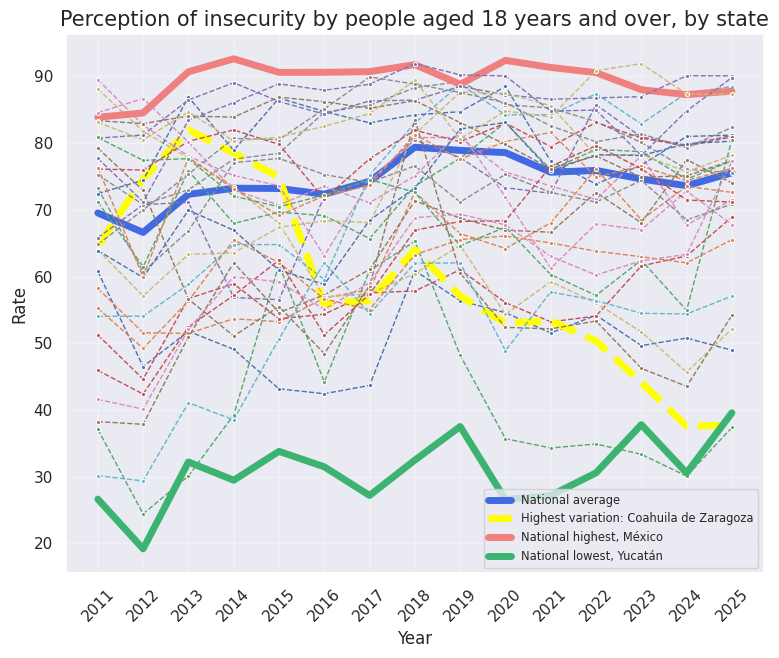

In [67]:
sns.set_theme(rc={'figure.figsize':(9,7)})
for state in new_security_by_state.columns:
    if state == 'Estados Unidos Mexicanos':
        sns.lineplot(x = new_security_by_state.index, y = new_security_by_state[state], linewidth = 5, label = 'National average', color = 'royalblue')
    elif state == 'Yucatán':
        sns.lineplot(x = new_security_by_state.index, y = new_security_by_state[state], linewidth = 5, label = 'National lowest, Yucatán', color = 'mediumseagreen')  
    elif state == 'México':
        sns.lineplot(x = new_security_by_state.index, y = new_security_by_state[state], linewidth = 5, label = 'National highest, México', color = 'lightcoral')
    elif state == 'Coahuila de Zaragoza':      
        sns.lineplot(x = new_security_by_state.index, y = new_security_by_state[state], linewidth = 5, linestyle = 'dashed', label = 'Highest variation: Coahuila de Zaragoza', color = 'yellow')        
    else:
        sns.lineplot(x = new_security_by_state.index, y = new_security_by_state[state], linestyle='dashed', linewidth = 1, marker = '.')

plt.legend(fontsize = 'x-small')
plt.grid(True, alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.title('Perception of insecurity by people aged 18 years and over, by state', wrap = True, size = 15)

# save plot 
state_plot_name = '4.2_insecurity_by_state'
plt.savefig(plot_dir + state_plot_name + '.png')

# show plot
plt.show()

#### 4.2.3 Analysis

Given the large number of states reprensented in the plot, it's not easy to understand much about individual states. However, what stands out is that: 

- Overall, it's not easy to spot many similarities or **patterns** among the states, solely by looking at the plots. However, some trends can be guessed: it looks like there has been a general decrease from 2011 to 2012, followed by an increase in 2012-2013. It's also possible to see a general increase after 2024. 

- The **national average** in perceived insecurity about people's state is quite high, with 74% of people considering their state as unsafe. Overall, between 2011 and 2025 national perceived insecurity has increased by 6% (value in 2025: 75.6%).

- **Yucatán** has been perceived by its inhabitants as the safest state, with an average level of perceived insecurity of 30.8%. However, insecurity has increased from 2011 to today (+12.9%). In 2025 the value was 39.6%. 

- In the state of **México**, the level of perceived insecurity has been quite high throughout the years, with 85%-95% of its inhabitants considering the State as unsafe, and an average level of insecurity of 89.4%. In 2025 perceived insecurity was 87.8%, 3.9% more than 2011. 

- The state **Coahuila de Zaragoza** has experienced the most change, with a degree of variation from the average (standard deviation) of 14%. The change has been overall positive: in 2025, perceived insecurity was 37.7%, -26% than 2011.  

### 4.3 Trends in perceived insecurity in 2011-2025, by state

To complement the lineplots, trends in perceived insecurity in each state are calculated, to find out if the situation has improved, got worse, or remained the same over the past 14 years.

#### 4.3.1 Statistics

For every state, [Numpy Polynomial Polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.polyfit.html)* is used to calculate the polynomial coefficients bewteen state and years (2011-2025). The polynomial coefficients returned are the intercept (where the line fitting the data meets the Y ax), and the slope (or steepness) of the line. Source: https://www.w3schools.com/datascience/ds_linear_slope.asp. 

In this case, the value of the slope is used as a way to classify trends in perceived insecurity. If the slope is a positive value, it means that the trend is positive (in this case, it means that perceived insecurity has increased). If the value is negative, it means that the trend is negative.** 

Another possible way to assess trends in perceived insecurity would have been to calculate the change between 2011 and 2025 (2025 value - 2011 value). 

*Numpy Polynomial Polyfit is the new version of [Numpy Polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html). 

**To show how the value of the slope can show a trend in the data, I created some examples in the Appendix of the project (8.2.2 Line fitting (appendix to 4.3.2)). 

For every state, the slope of the line fitting the data is calculated. The values are added to a new dataframe.

In [68]:
# calculate slopes using numpy.polynomial.polyfit(): https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
# create empty dataframe with state and slope columns. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
slopes = pd.DataFrame(data= {'state' : [], 'slope' : []})

for state in new_security_by_state:
    slope = npp.polyfit(years, new_security_by_state[state], 1)[1]    
    slope = np.round(slope, decimals = 1)
    # append row to df slopes. see: https://www.geeksforgeeks.org/pandas/how-to-add-one-row-in-an-existing-pandas-dataframe/
    slopes.loc[len(slopes)] = [state, slope]

# show dataframe
slopes.head(3)

,state,slope
0,Estados Unidos Mexicanos,0.5
1,Aguascalientes,0.1
2,Baja California,1.7


Based on the value of the slope, the state's perceived insecurity is classified as: 

- **improving**: if the value of the slope is less then -0.1, it means that overall, between 2011 and 2025, the level of insecurity perceived by inhabitants has decreased;
- **stable**: if the value of the slope is between -0.1 and 0.1, it means that overall, between 2011 and 2025, the level of insecurity perceived by inhabitants has remained stable;
- **worsening**: if the value of the slope is more then 0.1, it means that overall, between 2011 and 2025, the level of insecurity perceived by inhabitants has increased. 

The label is added to the dataframe.

In [69]:
# classify slope (perceived insecurity)
def classify_trend(row):
    if row['slope'] < -0.1:
        return 'improving'
    elif row['slope'] > 0.1:
        return 'worsening'
    else:
        return 'stable'

# add trends to dataframe. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
slopes['trend'] = slopes.apply(classify_trend, axis=1)

In [70]:
# show trends
slopes

,state,slope,trend
0,Estados Unidos Mexicanos,0.5,worsening
1,Aguascalientes,0.1,stable
2,Baja California,1.7,worsening
3,Baja California Sur,-0.3,improving
4,Campeche,0.9,worsening
5,Coahuila de Zaragoza,-2.8,improving
6,Colima,1.4,worsening
7,Chiapas,2.4,worsening
8,Chihuahua,-0.7,improving
9,Ciudad de México,0.4,worsening


#### 4.3.2 Plot: trends in perceived insecurity in Mexico, by state (2011-2025)

Values, labels and colors for the plots are defined.

In [71]:
# count values. see: https://pandas.pydata.org/docs/reference/api/pandas.Series.str.count.html
improving = slopes['trend'].str.count('improving').sum()
worsening = slopes['trend'].str.count('worsening').sum()
stable = slopes['trend'].str.count('stable').sum()

labels = ['Improving', 'Worsening', 'Stable']
values = [improving, worsening, stable]

In [72]:
# set colors, labels and theme
# adapted from chatgpt: https://chatgpt.com/s/t_695d7ac65eec81918c09f5e427a27747

# map colors
trend_colors = {
    "improving": "mediumseagreen",
    "stable": "royalblue",
    "worsening": "lightcoral"
}

colors = slopes['trend'].map(trend_colors)

# set labels for legend
legend_elements = [
    Patch(facecolor="mediumseagreen", label="Improving"),
    Patch(facecolor="royalblue", label="Stable"),
    Patch(facecolor="lightcoral", label="Worsening")
]


# set seaborne theme
sns.set_theme(rc={'figure.figsize':(5,5)},color_codes=True, palette= ['lightcoral', 'royalblue', 'mediumseagreen'])


Two subplots are created with Matplotlib to show trends in perceived insecurity by state (2011-2025). A bar plot shows the trend in perceived insecurity (through the steepness of the trend line), and a pie chart shows the % of improving, stable and worsening states. 

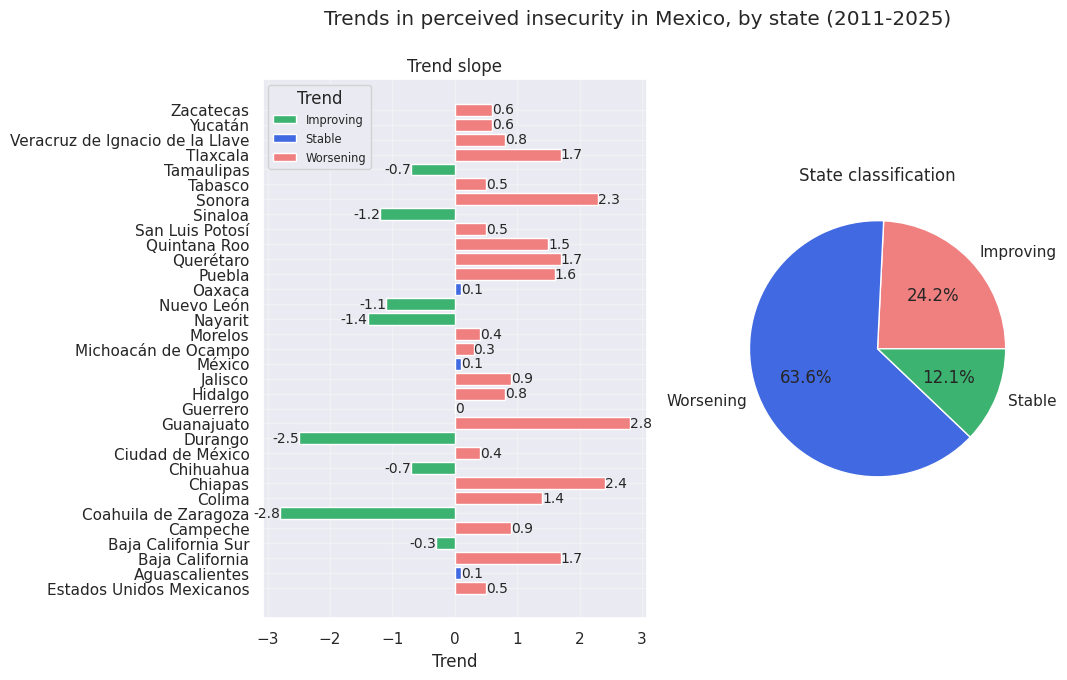

In [73]:
# Plot trends 

#https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={'width_ratios': [6, 5]})

# plot bar chart 
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barh.html
p = axes[0].barh(slopes['state'], width = slopes['slope'], color = colors)
axes[0].set_xlabel('Trend')
#https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.bar_label.html#matplotlib.axes.Axes.bar_label
axes[0].bar_label(p,fontsize = 'small' )
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html
axes[0].legend(handles=legend_elements, title="Trend", fontsize = 'x-small', loc = 'upper left')
axes[0].set_title('Trend slope')
axes[0].grid(True, alpha=0.3)

# plot pie chart
# https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html
axes[1].pie(values, labels = labels, autopct='%1.1f%%')
axes[1].set_title('State classification')

# add supltitle 
plt.suptitle('Trends in perceived insecurity in Mexico, by state (2011-2025)')

# save plot
trend_plot_name = '4.3_trends_perceived_insecurity'
plt.savefig(plot_dir + trend_plot_name + '.png')

# show plot
plt.show()

#### Analysis



### 4.4 Perceived insecurity in 2025, by state 

A snapshot perceived insecurity in Mexico is displayed, showing rates of perceived insecurity in the country in 2025. 

A .shp file is used to plot the shape of the country and its states. Data about perceived insecurity in each state is added to the file, and plotted as a heatmap with geopandas and matplotlib. 

In [74]:
# Import with .shp file 
map = gpd.read_file('./data/map/mex_admin1.shp')

# preview map table
map.head(5)

,adm1_name,adm1_name1,adm1_name2,adm1_name3,adm1_pcode,adm0_name,adm0_name1,adm0_name2,adm0_name3,adm0_pcode,...,area_sqkm,version,lang,lang1,lang2,lang3,adm1_ref_n,center_lat,center_lon,geometry
0,Aguascalientes,None,None,None,MX01,México,None,None,None,MX,...,5615.670486,v02,es,None,None,None,Aguascalientes,22.040951,-102.313154,"POLYGON ((-102.28787 22.41649, -102.28753 22.4..."
1,Baja California,None,None,None,MX02,México,None,None,None,MX,...,72853.585755,v02,es,None,None,None,Baja California,30.359352,-115.244131,"MULTIPOLYGON (((-114.79201 32.63022, -114.8019..."
2,Baja California Sur,None,None,None,MX03,México,None,None,None,MX,...,71966.826398,v02,es,None,None,None,Baja California Sur,25.435938,-111.543005,"MULTIPOLYGON (((-113.30833 28, -113.3 28, -113..."
3,Campeche,None,None,None,MX04,México,None,None,None,MX,...,55497.841605,v02,es,None,None,None,Campeche,19.330708,-89.943250,"MULTIPOLYGON (((-90.37936 20.84833, -90.38182 ..."
4,Chiapas,None,None,None,MX07,México,None,None,None,MX,...,72668.453027,v02,es,None,None,None,Chiapas,16.260164,-92.245241,"MULTIPOLYGON (((-93.27772 17.98235, -93.27738 ..."


A dictionary is created with the state and the value of perceived insecurity in 2025.

In [75]:
# get 2025 data 
latest_insecurity_data = {}
for state in new_security_by_state.columns:
        if state != 'Estados Unidos Mexicanos':
            latest_insecurity_data.update({state: (new_security_by_state[state].iloc[-1])})

latest_insecurity_data

{'Aguascalientes': np.float64(48.97),
 'Baja California': np.float64(72.62),
 'Baja California Sur': np.float64(37.39),
 'Campeche': np.float64(68.92),
 'Coahuila de Zaragoza': np.float64(37.72),
 'Colima': np.float64(81.17),
 'Chiapas': np.float64(74.03),
 'Chihuahua': np.float64(71.52),
 'Ciudad de México': np.float64(75.56),
 'Durango': np.float64(52.17),
 'Guanajuato': np.float64(88.49),
 'Guerrero': np.float64(81.21),
 'Hidalgo': np.float64(65.53),
 'Jalisco': np.float64(77.36),
 'México': np.float64(87.79),
 'Michoacán de Ocampo': np.float64(80.95),
 'Morelos': np.float64(90.09),
 'Nayarit': np.float64(54.18),
 'Nuevo León': np.float64(67.79),
 'Oaxaca': np.float64(70.86),
 'Puebla': np.float64(78.18),
 'Querétaro': np.float64(57.08),
 'Quintana Roo': np.float64(80.3),
 'San Luis Potosí': np.float64(76.25),
 'Sinaloa': np.float64(80.54),
 'Sonora': np.float64(71.17),
 'Tabasco': np.float64(89.83),
 'Tamaulipas': np.float64(77.4),
 'Tlaxcala': np.float64(77.27),
 'Veracruz de Igna

The data is remapped and added to the .shp file.

In [76]:
# adapted from chatGPT: https://chatgpt.com/s/t_6958d857aa10819183507d0af0bbaa53
# map to existing file 
map["2025_insecurity_state"] = map["adm1_name"].map(latest_insecurity_data)

# preview state and insecurity value
map[["adm1_name", "2025_insecurity_state"]].head()

,adm1_name,2025_insecurity_state
0,Aguascalientes,48.97
1,Baja California,72.62
2,Baja California Sur,37.39
3,Campeche,68.92
4,Chiapas,74.03


The map is plotted with matplotlib, showing levels of perceived insecurity in the country. 

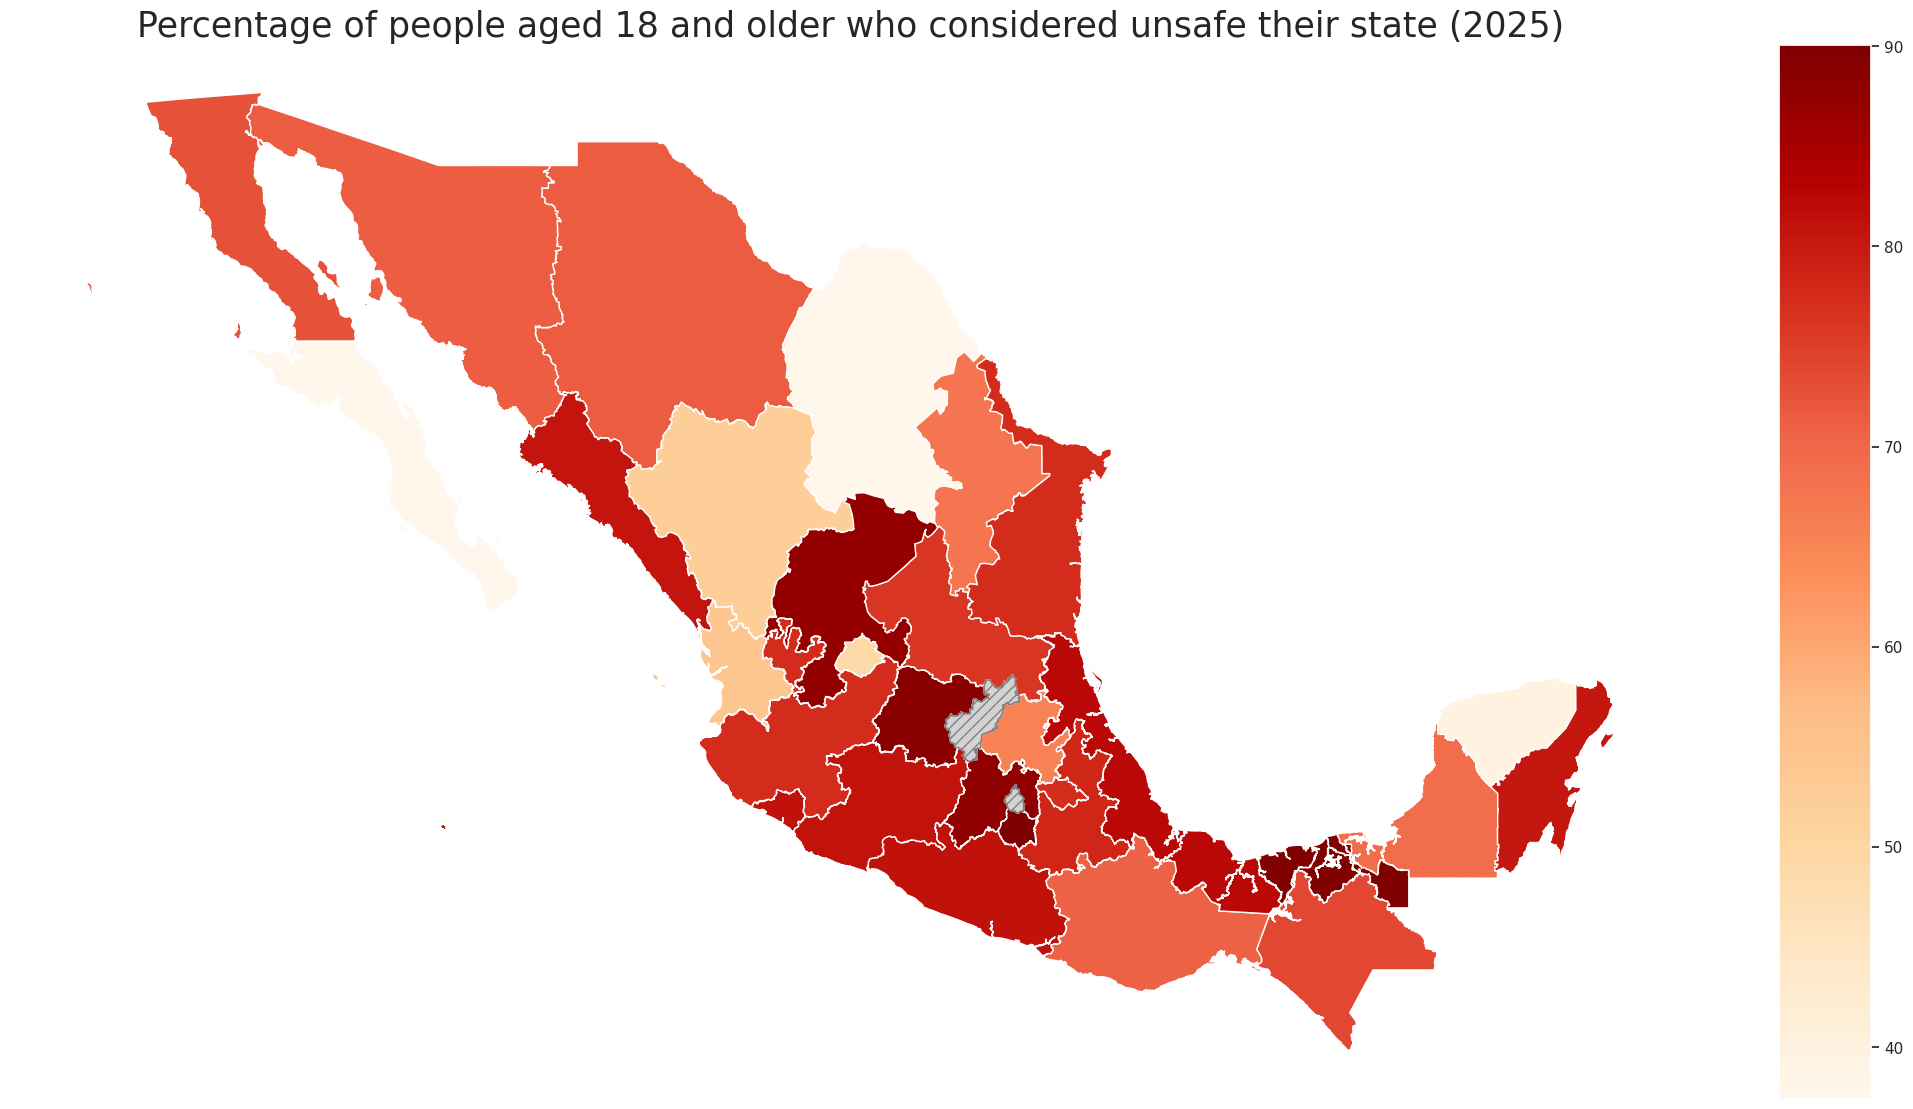

In [77]:
# plot map of Mexico 

# sources: 
# https://nbviewer.org/github/pysal/inequality/blob/main/docs/user-guide/measure/theil.ipynb
# https://www.youtube.com/watch?v=aGPQXD-rLgw
# legend: https://geopandas.org/en/stable/docs/user_guide/mapping.html#creating-a-legend
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_axis_off.html
# https://share.google/aimode/U1k86IMoMlSjQWVUh

fig, ax = plt.subplots(1, 1, figsize=(25, 18)) 
divider = make_axes_locatable(ax) 

cax = divider.append_axes("right", size="5%", pad=0.1) 
map.plot(
    column='2025_insecurity_state',
    ax=ax,
    cax=cax,
    legend=True,
    #legend_kwds={"label": "Rate every 100,000 inhabitants", "orientation": "vertical"},
    cmap='OrRd', 
    missing_kwds={"color": "lightgrey", "edgecolor": "Grey", "hatch": "///"}
);
ax.set_axis_off()
ax.set_title('Percentage of people aged 18 and older who considered unsafe their state (2025)', size = 25)

# save plot 
map_plot_name = '4.4_perceived_insecurity_2025'
plt.savefig(plot_dir + map_plot_name + '.png')

# show plot
plt.show()

## 5. Correlation between perceived insecurity and reported crime rates

**About this section**

This section focuses on **reported crime** and investigates correlations between crime rates and perceived insecurity over the past 14 years. 

The indicators for crime rates in the datasets are available only at national level. For this reason, it was not possible to compute correlations for individual states, although looking at local dimensions would more likely produce representative results - particularly considering the diversity within the country showin in the previous section. 

The crimes considered include both violent and non-violent crimes, and include, among the others: alcohol and drug usage, theft, homicide, shooting, fights, kidnapping, police violence...

### 5.1 Data prepatation

A dataframe is created selecting only indicators about "depositions" of crime. 

The term "deposition", in this case, is a bad translation for "reports" and refers to the crime types reported by citizens, when surveyed about the matter of perceived insecurity. This means that any person taking part in the survey could mention multiple crime types. 

Offense rates are expresses as percentages. 

In [78]:
# select subset for reports of crime
depositions = data[data['indicator'].str.contains('depositions of') |data['indicator'].str.contains('witnessed') ]

# show data (including unit of measure)
depositions.head(3)

,state ID,state,indicator ID,indicator,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,unit of measure
7,0,Estados Unidos Mexicanos,6200028417,Percentage of depositions of frequent shots,20.688461,17.117995,18.534586,20.695761,20.612828,20.833733,25.124182,30.104658,33.470799,32.232819,31.630257,31.023984,31.233243,31.604222,34.357405,Percentage
8,0,Estados Unidos Mexicanos,6200028418,Percentage of depositions of venues invasion,8.482702,5.933348,8.076629,11.155174,11.716482,11.029913,12.605875,14.077244,14.850252,14.020846,13.796389,16.062620,15.904820,15.526071,18.447114,Percentage
9,0,Estados Unidos Mexicanos,6200028419,Percentage of depositions of alcohol consumpti...,65.504083,62.075632,65.196063,64.077111,64.546358,63.824600,63.290773,66.395751,65.448236,64.213122,65.487380,64.606584,64.382391,63.141399,63.801925,Percentage


Irrelevant columns are removed. 

In [79]:
col_to_remove = ['state ID', 'state', 'unit of measure']

depositions = depositions.drop(columns = col_to_remove)

depositions.head(3)

,indicator ID,indicator,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
7,6200028417,Percentage of depositions of frequent shots,20.688461,17.117995,18.534586,20.695761,20.612828,20.833733,25.124182,30.104658,33.470799,32.232819,31.630257,31.023984,31.233243,31.604222,34.357405
8,6200028418,Percentage of depositions of venues invasion,8.482702,5.933348,8.076629,11.155174,11.716482,11.029913,12.605875,14.077244,14.850252,14.020846,13.796389,16.062620,15.904820,15.526071,18.447114
9,6200028419,Percentage of depositions of alcohol consumpti...,65.504083,62.075632,65.196063,64.077111,64.546358,63.824600,63.290773,66.395751,65.448236,64.213122,65.487380,64.606584,64.382391,63.141399,63.801925


Indicator names are shortened and added to the dataframe. These labels will be use in the plot legend. 

In [80]:
# make indicators shorter and set as titles 
# see: https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html 
# see: https://pandas.pydata.org/docs/reference/api/pandas.Series.str.title.html#pandas.Series.str.title
depositions['offense'] = depositions['indicator'].str.replace('Percentage of ', '', regex = False)
depositions['offense'] = depositions['offense'].str.replace('depositions of ', '', regex = False).str.title()

In [81]:
# show crime types
depositions[['indicator ID', 'offense']]

,indicator ID,offense
7,6200028417,Frequent Shots
8,6200028418,Venues Invasion
9,6200028419,Alcohol Consumption In The Street
10,6200028420,Homicide
11,6200028421,Unspecified
12,6200028422,Pirate Products Sale
13,6200028423,Witnessed Extortions (Right Of Floor Fee)
14,6200028424,Prostitution
15,6200028425,Theft Or Frequent Assaults
16,6200028426,Drug Consumption


Offenses are classified as either violent, non-violent, or none. The information is added to the dataframe. 

In [82]:
# classify offenses as violent, non-violent, and none
violent = [6200028417, 6200028418, 6200028420, 6200028423, 6200028425, 6200028430, 6200028431]

non_violent = [6200028419, 6200028422, 6200028424, 6200028426, 6200028427, 6200028428, 6200028429]

none = [6200028432, 6200028421]

In [83]:
# classify category 
def classify_category(row):
    indicator = row['indicator ID']

    if indicator in violent:
        return 'violent'
    elif indicator in non_violent:
        return 'non_violent'
    elif indicator in none:
        return 'stable'
    else:
        return ''

# add category to dataframe. 
# see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
depositions['offense type'] = depositions.apply(classify_category, axis=1) 

depositions.head(3)

,indicator ID,indicator,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,offense,offense type
7,6200028417,Percentage of depositions of frequent shots,20.688461,17.117995,18.534586,20.695761,20.612828,20.833733,25.124182,30.104658,33.470799,32.232819,31.630257,31.023984,31.233243,31.604222,34.357405,Frequent Shots,violent
8,6200028418,Percentage of depositions of venues invasion,8.482702,5.933348,8.076629,11.155174,11.716482,11.029913,12.605875,14.077244,14.850252,14.020846,13.796389,16.062620,15.904820,15.526071,18.447114,Venues Invasion,violent
9,6200028419,Percentage of depositions of alcohol consumpti...,65.504083,62.075632,65.196063,64.077111,64.546358,63.824600,63.290773,66.395751,65.448236,64.213122,65.487380,64.606584,64.382391,63.141399,63.801925,Alcohol Consumption In The Street,non_violent


The dataframe is re-arranged using [pandas.melt()](https://pandas.pydata.org/docs/reference/api/pandas.melt.html). This means that for each year column in the dataframe, a new row will be created. That row will retain the other columns. In the end, from each row in the dataframe, 15 rows will be produced, one for each year.  

In [84]:
# melt dataframe. see: https://pandas.pydata.org/docs/reference/api/pandas.melt.html
# adapted from chatGPT: https://chatgpt.com/share/695ec1ec-953c-800f-b1a0-d23048c0219b 

year_cols = [str(y) for y in range(2011, 2026)]

# rearragne dataframe with one row for each year
depositions_long = pd.melt(
    depositions,
    id_vars=["indicator ID", "indicator", "offense", "offense type"],
    value_vars=year_cols,
    var_name="year",
    value_name="value"
)

# change year to integers
depositions_long["year"] = depositions_long["year"].astype(int)

# preview new data
depositions_long.head(5)

,indicator ID,indicator,offense,offense type,year,value
0,6200028417,Percentage of depositions of frequent shots,Frequent Shots,violent,2011,20.688461
1,6200028418,Percentage of depositions of venues invasion,Venues Invasion,violent,2011,8.482702
2,6200028419,Percentage of depositions of alcohol consumpti...,Alcohol Consumption In The Street,non_violent,2011,65.504083
3,6200028420,Percentage of depositions of homicide,Homicide,violent,2011,17.673811
4,6200028421,Percentage of depositions of unspecified,Unspecified,stable,2011,1.037243


### 5.2 Plot: Perceived insecurity and reported offenses

Offense rates in 2011 to 2025 are plotted as scatter plots. Line plots showing national perceived inseucurity are added to the plots, to highlight significant patterns in the data. 

The data about national perceived insecurity is pulled again to create the lineplots. 

In [85]:
# get data about perceived insecurity in the country
national_insecurity = new_security_by_state.loc[:,'Estados Unidos Mexicanos']
national_insecurity.index = national_insecurity.index.astype(int)

national_insecurity.head(5)

2011    69.54
2012    66.62
2013    72.32
2014    73.25
2015    73.21
Name: Estados Unidos Mexicanos, dtype: float64

Offense types are mapped to set the plot titles. 

In [86]:
# map offense types
offense_types = ["violent", "non_violent"]
titles = {
    "violent": "Violent Offenses",
    "non_violent": "Non-Violent Offenses"
}

The plots are created using Matplotlib. These plots were created with the support of chatGPT, including several prompt iterations and other changes to reach the desired result. 

The Seaborn default theme is used, so that the plot follows the same style as the other plots in the project. 

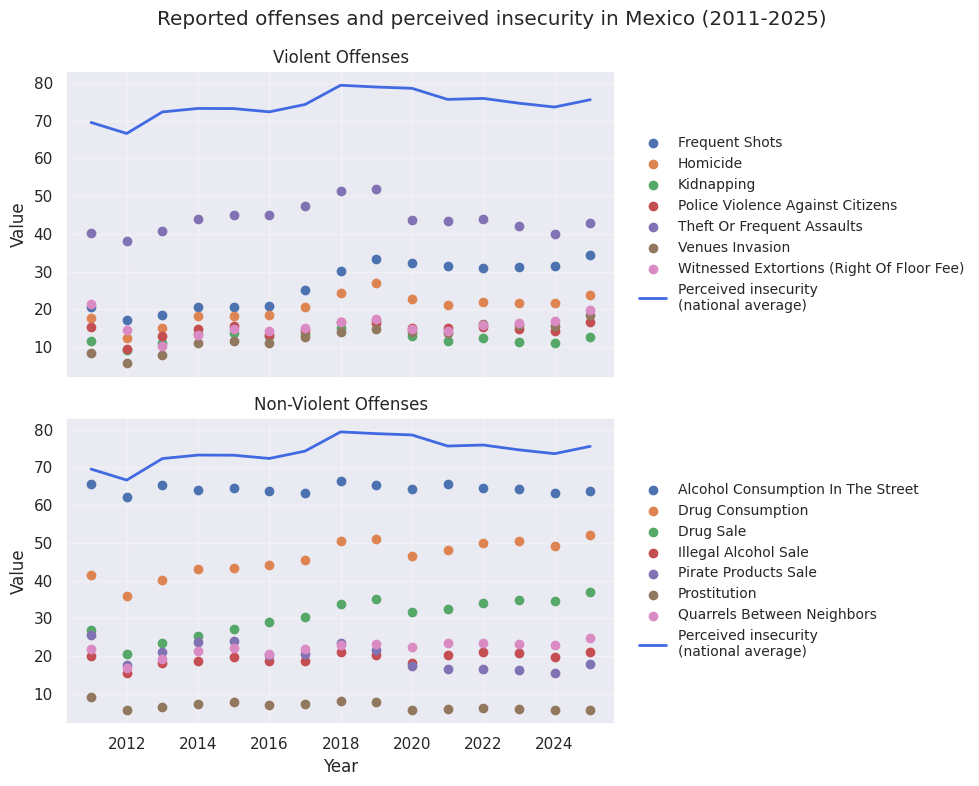

In [87]:
# set sns theme
sns.set_theme()


# plot scatter plots. Adapted from chatGPT: https://chatgpt.com/share/695ec1ec-953c-800f-b1a0-d23048c0219b 

# set layout 
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 8),
    sharex=True,
    sharey=True
)

# create the plots
for ax, offense_type in zip(axes, offense_types):
    subset = depositions_long[depositions_long["offense type"] == offense_type]

    # plot offenses in scatter plots 
    for offense, group in subset.groupby("offense"):
        ax.scatter(
            group["year"],
            group["value"],
            label=offense,
        )

    # plot perceived insecurity in line plots    
    ax.plot(
        national_insecurity.index,
        national_insecurity,
        label = f'Perceived insecurity \n(national average)',
        color = 'royalblue',
        linewidth = 2

    )

    # set title, labels, grid
    ax.set_title(titles[offense_type])
    ax.set_ylabel("Value")
    ax.grid(True, alpha=0.3)

    # set legends
    # see: https://matplotlib.org/stable/api/legend_api.html
    ax.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        fontsize="small",
        frameon=False
    )

# set y label (bottom only)
axes[-1].set_xlabel("Year")

#add suptitle
plt.suptitle('Reported offenses and perceived insecurity in Mexico (2011-2025)')
plt.tight_layout()

#save plot
offense_plot_name = '5_perceived_insecurity_vs_offenses'
plt.savefig(plot_dir + offense_plot_name + '.png')

# show plot
plt.show()

### 5.3 Analysis

The plots shows some interesting facts and patterns: 

**Offenses**

- **Alcohol** and **drug** consumption are the most common offenses, with an average of 64% and 46% of reports over the past 15 years. 
- **Thefts** and **shots** are the most common violent offenses, with an average of 44% and 26% over the past 15 years.  


**Offenses and perceived insecurity**

The plots highlight somes correlation between perceived insecurity and reported offenses, in particular for the following trends: 

- a general decrease in 2011-2012,
- a steady increase from 2012 to 2019, followed by a reduction and an increase again. 
- the correlation seem to concern, more or less, all offense types, making it a general trend. 

Interestingly, the offenses with the strongest correlation* to perceived insecurity are violent offenses: 
1. Homicide: 0.9
2. Drug consumption: 0.81
3. Frequent shots: 0.79. 

*Pearson's coefficient of correlation is calculated below to test the correlation between perceived insecurity and crime reports. See the section below for more information. 

### 5.4 Statistics

**Mean values**

Mean offense rates are calculated with [pandas.series.mean()](https://pandas.pydata.org/docs/reference/api/pandas.Series.mean.html).

In [88]:
# iterate through the dataframe to calculate mean for every offense 
rates = {}
for offense in depositions_long['offense']:
    rate = depositions_long[depositions_long['offense']== offense]['value'].mean()
    rates[offense] = round(rate,1)

rates

{'Frequent Shots': np.float64(26.6),
 'Venues Invasion': np.float64(12.8),
 'Alcohol Consumption In The Street': np.float64(64.4),
 'Homicide': np.float64(20.3),
 'Unspecified': np.float64(0.5),
 'Pirate Products Sale': np.float64(19.9),
 'Witnessed Extortions (Right Of Floor Fee)': np.float64(15.7),
 'Prostitution': np.float64(6.8),
 'Theft Or Frequent Assaults': np.float64(44.0),
 'Drug Consumption': np.float64(46.1),
 'Drug Sale': np.float64(30.4),
 'Quarrels Between Neighbors': np.float64(22.1),
 'Illegal Alcohol Sale': np.float64(19.5),
 'Kidnapping': np.float64(12.7),
 'Police Violence Against Citizens': np.float64(14.7),
 'None': np.float64(12.5)}

**Correlation**

Pearson correlation coefficient is calculated with [pandas.corr()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) to show the correlation between perceived insecurity and criminal offenses. Pearson correlation is a linear correlation, and represents the covariance of two variables, that is, how much one variable changes, when the other one changes. 

It is a number between 1 and -1, where 1 represents a perfect positive correlation, 0 no correlation, and - 1 a perfect negative correlation. 

Source: https://realpython.com/numpy-scipy-pandas-correlation-python/#linear-correlation

In [89]:
# add national insecurity to depositions dataframe
depositions_long["perceived insecurity"] = depositions_long["year"].map(national_insecurity)

depositions_long.head(5)

,indicator ID,indicator,offense,offense type,year,value,perceived insecurity
0,6200028417,Percentage of depositions of frequent shots,Frequent Shots,violent,2011,20.688461,69.54
1,6200028418,Percentage of depositions of venues invasion,Venues Invasion,violent,2011,8.482702,69.54
2,6200028419,Percentage of depositions of alcohol consumpti...,Alcohol Consumption In The Street,non_violent,2011,65.504083,69.54
3,6200028420,Percentage of depositions of homicide,Homicide,violent,2011,17.673811,69.54
4,6200028421,Percentage of depositions of unspecified,Unspecified,stable,2011,1.037243,69.54


In [90]:
# calculate correlations. see: https://chatgpt.com/s/t_69602320d1048191a76e674b836b9a5a. 
correlations = (
    depositions_long
    .groupby("offense")
    .apply(lambda x: x["value"].corr(x["perceived insecurity"]), include_groups=False)
    .reset_index(name="pearson_r")
)

# see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
correlations.sort_values(by=['pearson_r'], ascending = False)

,offense,pearson_r
4,Homicide,0.904057
1,Drug Consumption,0.819853
3,Frequent Shots,0.795815
9,Police Violence Against Citizens,0.766899
2,Drug Sale,0.766744
14,Venues Invasion,0.753095
12,Theft Or Frequent Assaults,0.747956
11,Quarrels Between Neighbors,0.733566
6,Kidnapping,0.724301
5,Illegal Alcohol Sale,0.636333


## 7. Conclusion

## 8. Appendix

### 8.1 A map of Mexico 

Geopandas is used to plot a map of Mexico with legend. 

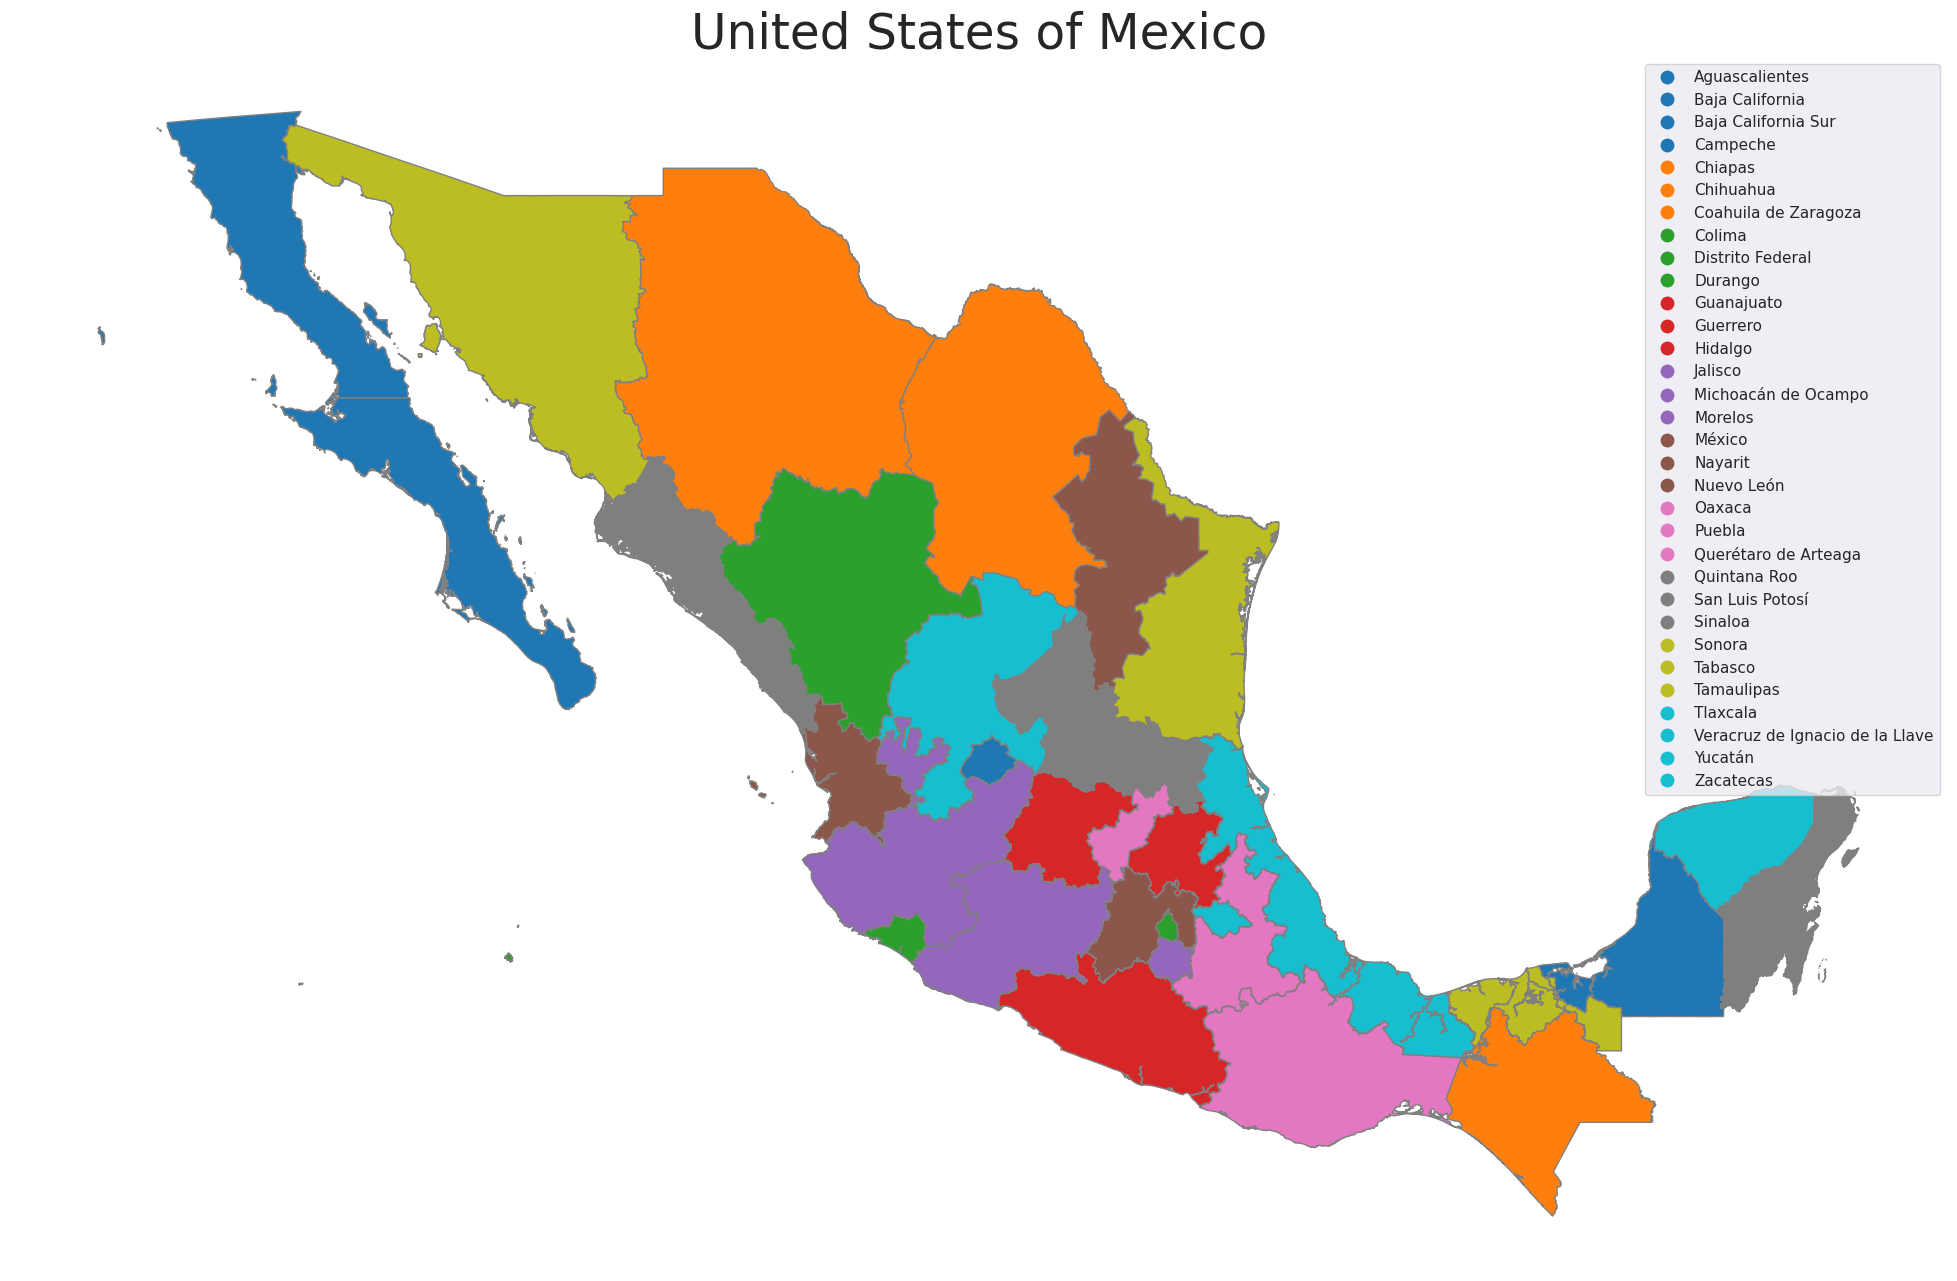

In [91]:
# https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot
plt.rcParams['figure.figsize'] = [25, 25]
map.plot(column='adm1_name', legend=True, edgecolor="grey")
plt.title('United States of Mexico', size = 35)
plt.axis('off')

plt.show()

### 8.2 Line fitting

This section shows how the polynomial coefficients (in paerticular the slope), can highlight a trend in the data. The plots show the data points for the state of Yucatán and México (lowest and highest levels of perceived insecurity). 

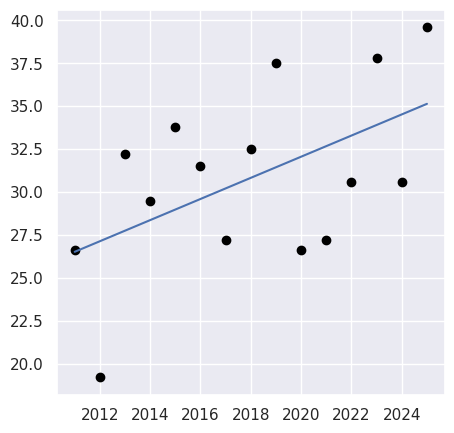

In [92]:
# source: https://share.google/aimode/XuLDKflJEzJ2EsR8y 
x = new_security_by_state.index.astype(int)
y = round(new_security_by_state['Yucatán'],1)

p = np.polyfit(x, y, 1)
s = p[0]
i = p[1]

y_fit = s * x + i

fig, ax = plt.subplots(figsize = [5,5])

ax.scatter(x, y, color = 'black')
ax.plot(x, y_fit)
plt.show()

## End